In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from utility.ffqd_mnist import FFQD_Dataset
from torch.utils.data import DataLoader

training_data = FFQD_Dataset('ffqd_mnist/', train=True)
train_dataloader = DataLoader(training_data, batch_size=64)

test_data = FFQD_Dataset('ffqd_mnist/')
test_dataloader = DataLoader(test_data, batch_size=64)

In [3]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_size = 784, output_size=10):
        super(Perceptron, self).__init__()
        self.fc = torch.nn.Linear(input_size,output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        y = self.fc(x)
        y = self.relu(y)
        return y

In [4]:
model = Perceptron()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
# criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()
device = 'cpu'

def reset_model():
    global model, optimizer
    model = Perceptron()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)


In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch_id, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # calculate loss
        y_pred = model(X)
        # loss = loss_fn(y_pred.float(), y.float())
        loss = loss_fn(y_pred, y)


        # print( y_pred.dtype, y_pred.shape)
        # print(loss)

        # backprop loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(f"({batch_id}) loss: {loss:>7}")


In [6]:
def test_one_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            test_loss += loss_fn(pred_y, y).item()
            correct += (pred_y.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [7]:
reset_model()
# old_weights = torch.Tensor(np.array(model.get_parameter("fc.weight").detach().numpy())) # copy old weights
old_weights = model.get_parameter("fc.weight").clone().detach()
for i in range(5):
    train_one_epoch(train_dataloader, model, criterion, optimizer)
    print(test_one_epoch(test_dataloader, model, criterion))

(0) loss: 2.2954271882772446
(100) loss: 1.8175238110125065
(200) loss: 1.6769997980445623
(300) loss: 1.434285947587341
(400) loss: 1.3969567292369902
(500) loss: 1.4741743949707597
(600) loss: 1.1604290748946369
(700) loss: 1.176316688535735
(800) loss: 1.079838422127068
(1.1232389165066199, 0.6864181818181818)
(0) loss: 1.1685230010189116
(100) loss: 1.0906444853171706
(200) loss: 1.0144397227559239
(300) loss: 0.8089867323869839
(400) loss: 0.9703737152740359
(500) loss: 0.968867810734082
(600) loss: 0.9341727383434772
(700) loss: 0.7501991924073081
(800) loss: 0.8148869012948126
(0.8312357580721049, 0.7574181818181818)
(0) loss: 0.9112061369232833
(100) loss: 0.7516681090346538
(200) loss: 0.852995196095435
(300) loss: 0.6329431136837229
(400) loss: 0.8801914459909312
(500) loss: 0.8728132142568938
(600) loss: 0.8678382358630188
(700) loss: 0.6649345965415705
(800) loss: 0.7557842504174914
(0.7738039119115301, 0.7706363636363637)
(0) loss: 0.8588355747633614
(100) loss: 0.67850278

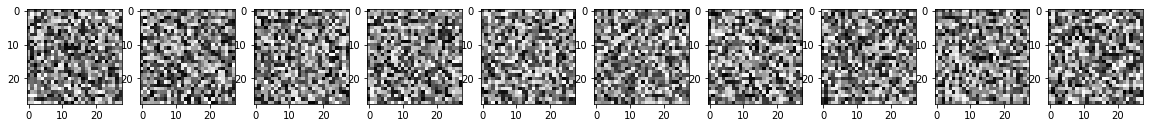

In [8]:
f, axs = plt.subplots(1,10,figsize=(20,20))
axs = axs.flatten()
for i, w in enumerate(old_weights):
    axs[i].imshow(w.view(28,28), cmap="gray")

In [9]:
for name, par in model.named_parameters():
    print(name, par.data, par.data.shape)

fc.weight tensor([[-0.0167, -0.0024, -0.0303,  ..., -0.0077,  0.0230,  0.0214],
        [-0.0047,  0.0175, -0.0113,  ..., -0.0138,  0.0002, -0.0149],
        [-0.0281, -0.0048, -0.0257,  ...,  0.0073, -0.0153, -0.0090],
        ...,
        [ 0.0208,  0.0349,  0.0140,  ...,  0.0355, -0.0236,  0.0120],
        [-0.0213, -0.0092, -0.0240,  ...,  0.0049, -0.0247,  0.0181],
        [-0.0058,  0.0184, -0.0101,  ..., -0.0260, -0.0120,  0.0258]]) torch.Size([10, 784])
fc.bias tensor([ 0.0030,  0.1504,  0.2064, -0.1746, -0.1345, -0.3638,  0.2096,  0.3836,
         0.6446, -0.2258]) torch.Size([10])


In [10]:
weights = model.get_parameter("fc.weight").detach()

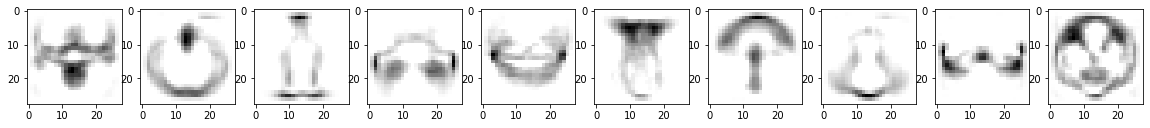

In [11]:
f, axs = plt.subplots(1,10,figsize=(20,20))
axs = axs.flatten()
for i, w in enumerate((weights-old_weights).clip(min=0)):
    pcm = axs[i].imshow(w.view(28,28), cmap="gray_r")
    # f.colorbar(pcm, ax=axs[i])
    # plt.clim(0,1)
